# Introduction

Dans ce notebook, nous allons essayer de mettre en place des modèles de réseaux de neurones récurrents sur les données PM issus de capteurs de la sud 3. Ce notebook fait suite au notebook 3. dans lequel nous avons essayé des séquences de grandes taille sans succès. Ici nous avons essayé des séquences de moins de 16 points. Dans le notebook 3. en revanche, les séquences testées ont varié de 24 à 200 points.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
DATA_PATH = "../../data/clean/sud3_pm_normalized.pkl"
PATIENCE = 3

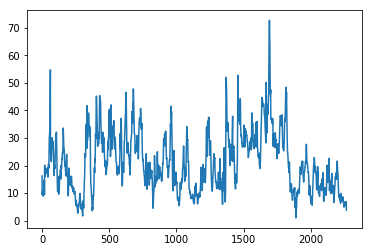

,index,date,ref,PM_6182,PM_6179,PM_617B,PM25_6182,PM25_6179,PM25_617B,rh,t_grad,pressure,temp,pluvio
2257,2458,2017-10-24 00:45:00,6.5,-1.132496,-1.091708,-1.139855,-1.127509,-1.095286,-1.134111,1.333691,-0.210703,0.504699,-0.282388,0.0
2258,2459,2017-10-24 01:00:00,6.6,-1.103150,-1.192272,-1.101750,-1.096106,-1.192185,-1.099147,1.370024,-0.265368,0.504699,-0.282388,0.0
2259,2460,2017-10-24 01:15:00,5.8,-0.991635,-1.245200,-0.978966,-0.989339,-1.237785,-0.989259,1.370024,-0.265368,0.504699,-0.282388,0.0
2260,2461,2017-10-24 01:30:00,5.5,-1.026851,-1.049366,-0.932392,-1.020741,-1.049687,-0.934316,1.397274,-0.265368,0.504699,-0.282388,0.0
2261,2462,2017-10-24 01:45:00,6.1,-1.067935,-0.906460,-1.089048,-1.058424,-0.912888,-1.094152,1.397274,-0.265368,0.504699,-0.282388,0.0
2262,2463,2017-10-24 02:00:00,5.9,-0.944682,-1.017609,-1.072112,-0.945376,-1.021187,-1.069177,1.415441,-0.265368,0.466311,-0.258799,0.0
2263,2464,2017-10-24 02:15:00,6.7,-0.997505,-1.038780,-1.042475,-1.001900,-1.038287,-1.039208,1.424524,-0.265368,0.466311,-0.258799,0.0
2264,2465,2017-10-24 02:30:00,6.9,-1.073804,-1.049366,-1.139855,-1.070985,-1.049687,-1.139105,1.406357,-0.265368,0.427923,-0.258799,0.0
2265,2466,2017-10-24 02:45:00,5.0,-1.009243,-1.245200,-1.211832,-0.995620,-1.237785,-1.214028,1.397274,-0.265368,0.447117,-0.235209,0.0
2266,2467,2017-10-24 03:00:00,3.8,-1.050327,-1.329885,-1.233002,-1.039583,-1.328984,-1.239003,1.397274,-0.265368,0.485505,-0.235209,0.0


In [3]:
df = pd.read_pickle(DATA_PATH)
df = df.reset_index()
df = df.dropna()

plt.plot(df["ref"])
plt.show()
df.tail(10)

In [4]:
df.describe()

,index,ref,PM_6182,PM_6179,PM_617B,PM25_6182,PM25_6179,PM25_617B,rh,t_grad,pressure,temp,pluvio
count,2267.000000,2267.000000,2.267000e+03,2.267000e+03,2.267000e+03,2.267000e+03,2.267000e+03,2.267000e+03,2.267000e+03,2.267000e+03,2.267000e+03,2.267000e+03,2267.000000
mean,1239.796648,21.212086,2.068629e-15,-1.786543e-15,-3.510401e-16,-8.023773e-16,-2.037286e-15,2.632801e-15,-5.973950e-15,4.137258e-16,1.769493e-13,8.224368e-15,0.018747
std,705.400522,10.602717,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.124942
min,15.000000,1.000000,-1.390741e+00,-1.488669e+00,-1.499741e+00,-1.391287e+00,-1.482882e+00,-1.503731e+00,-2.790105e+00,-1.850653e+00,-2.796663e+00,-2.240325e+00,0.000000
25%,639.500000,12.700000,-7.509984e-01,-7.582612e-01,-7.545665e-01,-7.506825e-01,-7.532899e-01,-7.495057e-01,-6.192077e-01,-7.026877e-01,-3.782235e-01,-6.362325e-01,0.000000
50%,1228.000000,19.500000,-2.814626e-01,-2.395657e-01,-2.973006e-01,-2.796498e-01,-2.459951e-01,-2.999675e-01,2.618677e-01,-2.653676e-01,4.404367e-02,-1.172612e-01,0.000000
75%,1858.500000,28.500000,5.196829e-01,5.808201e-01,6.574538e-01,5.305265e-01,5.861964e-01,6.715344e-01,8.341126e-01,3.359475e-01,6.390566e-01,5.668372e-01,0.000000
max,2467.000000,72.700000,4.138043e+00,3.587137e+00,3.453974e+00,4.116656e+00,3.567266e+00,3.376256e+00,1.424524e+00,4.381158e+00,1.790694e+00,3.185283e+00,4.300000


# Pré-traitement

On définit dans un premier des méthodes afin de transformer notre jeu de données en séquences.

In [5]:
def split_dataframe(dataframe, percent):
    nb_rows = int(np.floor(percent * len(dataframe)))
    return dataframe[:nb_rows], dataframe[nb_rows:]

def dataframe_to_xy(df, look_back):
    X, y = [], []
    i = look_back
    while i < len(df):
        sequence = df.iloc[i - look_back:i]
        X.append(np.array(sequence[['PM_6182', 'PM_6179', 'PM_617B', 'PM25_6182', 'PM25_6179', 'PM25_617B', 'temp', 'rh',\
                                 't_grad', 'pressure', 'pluvio']]).reshape(look_back, 1, 11))
        y.append(np.array(df.iloc[i]['ref']))
        i += 1
        if i == len(df):
            break
    X = np.array(X)
    y = np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], X.shape[3]))
    return X, y

df_test, df_train = split_dataframe(df, 0.5) 
df_valid, df_test = split_dataframe(df_test, 0.5)

X_train, y_train = dataframe_to_xy(df_train, 8)
X_valid, y_valid = dataframe_to_xy(df_valid, 8)
X_test, y_test = dataframe_to_xy(df_test, 8)

# Modèles

Nous allons tester 3 modèles récurrents: un modèle récurrent simple (SimpleRNN), un modèle LSTM et un modèle GRU

In [6]:
from keras.layers import SimpleRNN, Dense, LSTM, GRU, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=PATIENCE)

def simple_rnn_model(nb_units, input_dim, loss='mean_squared_error', optimizer=Adam(lr=3e-4)):
    model = Sequential()
    model.add(SimpleRNN(nb_units, activation='tanh', input_shape=input_dim))
    model.add(Dense(nb_units//2, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

def lstm_model(nb_units, input_dim, loss='mean_squared_error', optimizer=Adam(lr=3e-4)):
    model = Sequential()
    model.add(LSTM(nb_units, activation='tanh', input_shape=input_dim))
    model.add(Dense(nb_units//2, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

def gru_model(nb_units, input_dim, loss='mean_squared_error', optimizer=Adam(lr=3e-4)):
    model = Sequential()
    model.add(GRU(nb_units, activation='tanh', input_shape=input_dim))
    model.add(Dense(nb_units//2, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

Using TensorFlow backend.


## Simple RNN

### Apprentissage

In [7]:
model = simple_rnn_model(32, X_train.shape[1:])
history = model.fit(X_train, y_train, batch_size=16, epochs=1000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 32)                1408      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 1,953
Trainable params: 1,953
Non-trainable params: 0
_________________________________________________________________
Train on 1126 samples, validate on 558 samples
Epoch 1/1000
1126/1126 [==============================] - 0s 271us/step - loss: 589.7249 - val_loss: 539.4440
Epoch 2/1000
1126/1126 [==============================] - 0s 133us/step - loss: 577.4913 - val_loss: 521.5517
Epoch 3/1000
1126/1126 [==============================] - 0s 137us/step - loss: 537.3146 - val_loss: 465.1477
Epoch 4/1000
1126/1126 [===

### Courbes de résultats pour modèle RNN

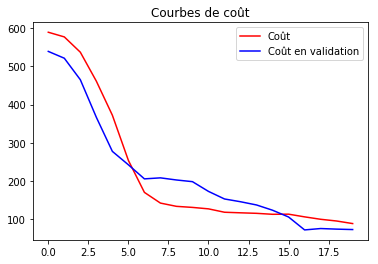

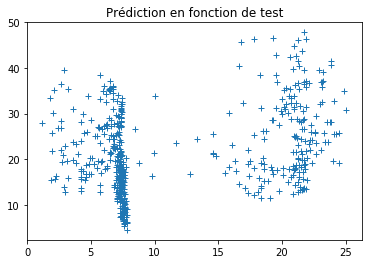

In [8]:
y_pred = model.predict(X_test)
plt.plot(history.history['loss'], 'r-', label="Coût")
plt.plot(history.history['val_loss'], 'b-', label="Coût en validation")
plt.title("Courbes de coût")
plt.legend()
plt.show()

plt.title('y_pred, y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.title("Prédiction en fonction de test")
plt.show()

## LSTM

### Apprentissage

In [9]:
model = lstm_model(32, X_train.shape[1:])
history = model.fit(X_train, y_train, batch_size=16, epochs=5000, validation_data=(X_valid, y_valid), callbacks=[early_stopping,], verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5632      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 6,177
Trainable params: 6,177
Non-trainable params: 0
_________________________________________________________________
Train on 1126 samples, validate on 558 samples
Epoch 1/5000
1126/1126 [==============================] - 1s 671us/step - loss: 592.3880 - val_loss: 546.1519
Epoch 2/5000
1126/1126 [==============================] - 0s 375us/step - loss: 583.9804 - val_loss: 533.5531
Epoch 3/5000
1126/1126 [==============================] - 0s 389us/step - loss: 544.5642 - val_loss: 489.3396
Epoch 4/5000
1126/1126 [===

### Courbes de résultats pour modèle LSTM

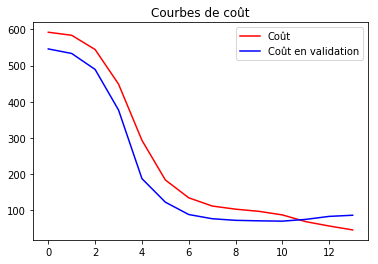

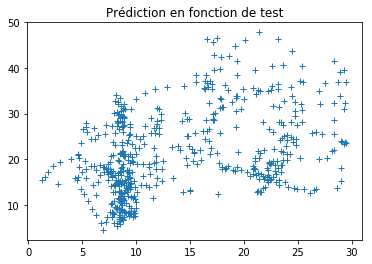

In [10]:
y_pred = model.predict(X_test)
plt.plot(history.history['loss'], 'r-', label="Coût")
plt.plot(history.history['val_loss'], 'b-', label="Coût en validation")
plt.title("Courbes de coût")
plt.legend()
plt.show()

plt.title('y_pred, y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.title("Prédiction en fonction de test")
plt.show()

## GRU

### Apprentissage

In [11]:
model = gru_model(32, X_train.shape[1:])
history = model.fit(X_train, y_train, batch_size=16, epochs=5000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                4224      
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________
Train on 1126 samples, validate on 558 samples
Epoch 1/5000
1126/1126 [==============================] - 1s 580us/step - loss: 588.1860 - val_loss: 542.7662
Epoch 2/5000
1126/1126 [==============================] - 0s 300us/step - loss: 573.9885 - val_loss: 526.7998
Epoch 3/5000
1126/1126 [==============================] - 0s 305us/step - loss: 532.3598 - val_loss: 484.9413
Epoch 4/5000
1126/1126 [===

### Courbes de résultats pour modèle GRU

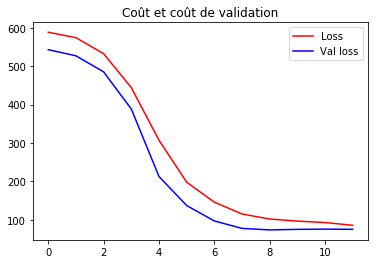

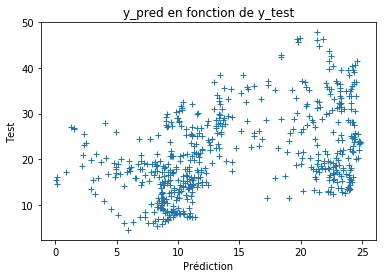

In [12]:
y_pred = model.predict(X_test)
plt.title('Coût et coût de validation')
line1,=plt.plot(history.history['loss'], label="Loss", linestyle='-', color='r')
line2,=plt.plot(history.history['val_loss'], label="Val loss", linestyle='-', color='b')
first_legend = plt.legend(handles=[line1, line2], loc=1)

plt.show()

plt.title('y_pred en fonction de y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.ylabel('Test')
plt.xlabel('Prédiction')
plt.show()

# Conclusion

Nous avons testé des modèles récurrents avec des séquences de points. Avec des séquences plus faibles, le réseau arrive à passer le palier de 106 de val_loss identifié dans le notebook précédent (pour les modèles **SimpleRNN** et **LSTM**. Plusieurs tests ont été effectués pour passer ce palier et la seule combinaison marchant pour passer le palier est celle présentée dans le notebook à savoir une seule couche récurrente et une seule couche Dense. Il a également été testé des apprentissages avec petit batch size et *stochastic gradient descent (SGD)* avec faible pas sans amélioration. La callback keras **ReduceLROnPlateau** a également été testée en combinaison avec la callback **EarlyStopping** elle aussi sans amélioration.

En augmentant le nombres d'unités pour les couches récurrentes et Denses du modèle présenté, le coût stagne au palier de 106 à nouveau. Egalement, en rajoutant une couche Dense après la couche récurrente, le problème subsiste.

Il est intéressant de noter que pour le modèle décrit dans le notebook, si l'on augmente/diminue la séquence donc le **look_back** à 16/8, le palier réapparaît. 